# DeepLabv3 Using Pytorch

## Import and Load Libraries

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models 
from torchsummary import summary
import torch.optim as optim
import time
import matplotlib.pyplot as plt

from tqdm import tqdm

import torchvision.transforms as transforms
from torchvision.models import resnet50, resnet101
import matplotlib.pyplot as plt
from torch.optim import Adam, RMSprop, SGD
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score
import tifffile as tiff
from PIL import Image
from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

## Load and Prepare Dataset

In [2]:
def load_images_and_labels_9_channels(data_path):
    images_path = os.path.join(data_path, 'images')
    labels_path = os.path.join(data_path, 'labels')
    
    scaler = MinMaxScaler()

    images = []
    labels = []
    
    for filename in os.listdir(images_path):
        if filename.endswith('.tif'):  
            image = tiff.imread(os.path.join(images_path, filename))
            # Remove the first 3 RGB channels, use only the remaining 9 channels
            channels_9_image = image[:, :, 3:]  # Channels 4 to 12
            reshaped_image = channels_9_image.reshape(-1, 9)
            normalized_image = scaler.fit_transform(reshaped_image).reshape(128, 128, 9)  # MinMaxScaler normalization
            
            # Load the label
            label_filename = filename.replace('.tif', '.png') 
            label = Image.open(os.path.join(labels_path, label_filename)).convert("L")
            label = label.resize((128, 128))
            label = np.array(label, dtype=np.float32) / 255.0  # Normalize to [0, 1]
            
            images.append(normalized_image)
            labels.append(label)

    images = torch.tensor(np.array(images), dtype=torch.float32).permute(0, 3, 1, 2)  # From (batch_size, 128, 128, 9) to (batch_size, 9, 128, 128)
    labels = torch.tensor(np.array(labels), dtype=torch.float32).unsqueeze(1) 
    return images, labels

data_path = r"D:\Mohamed Sheriff\Projects\Computer Vision Internship - Cellula Technologies\Water Segementation\Dataset"
images, labels = load_images_and_labels_9_channels(data_path)

print(f"Loaded {len(images)} images with shape {images[0].shape} and {len(labels)} labels with shape {labels[0].shape}")


Loaded 306 images with shape torch.Size([9, 128, 128]) and 306 labels with shape torch.Size([1, 128, 128])


### Splitting Dataset to $Train-Validation-Test$

In [3]:
train_dataset = TensorDataset(images, labels)

In [4]:
dataset_size = len(train_dataset)
indices = list(range(dataset_size))

train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=365)
val_indices, test_indices = train_test_split(val_indices, test_size=0.4, random_state=365)

train_dataset_subset = Subset(train_dataset, train_indices)
val_dataset_subset = Subset(train_dataset, val_indices)
test_dataset_subset = Subset(train_dataset, test_indices)

train_loader = DataLoader(train_dataset_subset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset_subset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset_subset, batch_size=8, shuffle=False)

print(f"Training set size: {len(train_dataset_subset)}")
print(f"Validation set size: {len(val_dataset_subset)}")
print(f"Test set size: {len(test_dataset_subset)}")

Training set size: 244
Validation set size: 37
Test set size: 25


## Building Custom DeepLabv3+ Model Architecture 

In [5]:
class DeepLabV3Plus(nn.Module):
    def __init__(self):
        super(DeepLabV3Plus, self).__init__()
        
        # New first layer to convert 9 input channels to 3 channels (as expected by ResNet50)
        self.new_first_layer = nn.Conv2d(in_channels=9, out_channels=3, kernel_size=1, padding=0)

        # Pretrained ResNet50 backbone
        resnet = resnet50(pretrained=False)
        self.resnet = nn.Sequential(*list(resnet.children())[:-2])  # Remove the top FC layers

        # Decoding layers
        self.conv5a = nn.Conv2d(2048 + 512, 512, kernel_size=3, padding=1)  # Update input channels to 2048+512 = 2560
        self.conv5b = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.dropout5 = nn.Dropout(0.3)
        
        self.conv6a = nn.Conv2d(512 + 256, 256, kernel_size=3, padding=1)
        self.conv6b = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.dropout6 = nn.Dropout(0.3)
        
        self.conv7a = nn.Conv2d(256 + 64, 128, kernel_size=3, padding=1)
        self.conv7b = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(128)
        self.dropout7 = nn.Dropout(0.4)

        self.output_conv = nn.Conv2d(128, 1, kernel_size=1, padding=0)
        
    def forward(self, x):
        # First layer: adjust from 9 input channels to 3
        x = self.new_first_layer(x)

        # Extract layers from ResNet50
        conv1 = self.resnet[:3](x)     # conv1_relu, downsampled 2x
        conv2 = self.resnet[3:5](conv1) # conv2_block3_out, downsampled 4x
        conv3 = self.resnet[5:6](conv2) # conv3_block4_out, downsampled 8x
        conv4 = self.resnet[6:](conv3)  # conv4_block6_out, downsampled 16x

        # Decode
        up5 = F.interpolate(conv4, scale_factor=2, mode='bilinear', align_corners=True)
        if up5.size()[2:] != conv3.size()[2:]:
            up5 = F.interpolate(up5, size=conv3.size()[2:], mode='bilinear', align_corners=True)
        concat5 = torch.cat([up5, conv3], dim=1)
        conv5 = F.relu(self.conv5a(concat5))
        conv5 = F.relu(self.conv5b(conv5))
        conv5 = self.bn5(conv5)
        conv5 = self.dropout5(conv5)

        up6 = F.interpolate(conv5, scale_factor=2, mode='bilinear', align_corners=True)
        if up6.size()[2:] != conv2.size()[2:]:
            up6 = F.interpolate(up6, size=conv2.size()[2:], mode='bilinear', align_corners=True)
        concat6 = torch.cat([up6, conv2], dim=1)
        conv6 = F.relu(self.conv6a(concat6))
        conv6 = F.relu(self.conv6b(conv6))
        conv6 = self.bn6(conv6)
        conv6 = self.dropout6(conv6)

        up7 = F.interpolate(conv6, scale_factor=2, mode='bilinear', align_corners=True)
        if up7.size()[2:] != conv1.size()[2:]:
            up7 = F.interpolate(up7, size=conv1.size()[2:], mode='bilinear', align_corners=True)
        concat7 = torch.cat([up7, conv1], dim=1)
        conv7 = F.relu(self.conv7a(concat7))
        conv7 = F.relu(self.conv7b(conv7))
        conv7 = self.bn7(conv7)

        up8 = F.interpolate(conv7, size=(128, 128), mode='bilinear', align_corners=True)

        # Output layer
        output = torch.sigmoid(self.output_conv(up8))

        return output

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize model and move it to the GPU
    model = DeepLabV3Plus().to(device)

    # Example input tensor (9 channels, move it to the GPU)
    input_tensor = torch.randn(1, 9, 128, 128).to(device)

    # Forward pass
    output = model(input_tensor)

    # Print output shape to confirm
    print(f"Output shape: {output.shape}")

    # Loss and optimizer
    optimizer = Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()

    # Example target tensor (move it to the GPU)
    target = torch.randn(1, 1, 128, 128).to(device)

    # Resize the target tensor to match output size and ensure it's in range [0, 1]
    target_resized = F.interpolate(target, size=output.size()[2:], mode='bilinear', align_corners=True)
    target_resized = torch.clamp(target_resized, 0, 1)

    # Compute the loss
    loss = criterion(output, target_resized)
    print(f"Loss: {loss.item()}")
summary(model, input_size=(9, 128, 128)) # (channels, height, width)

D:\Mohamed Sheriff\Programs\Anaconda3 - Jupiter\envs\torch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Mohamed Sheriff\Programs\Anaconda3 - Jupiter\envs\torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Output shape: torch.Size([1, 1, 128, 128])
Loss: 0.7307831048965454
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 128, 128]              30
            Conv2d-2           [-1, 64, 64, 64]           9,408
       BatchNorm2d-3           [-1, 64, 64, 64]             128
              ReLU-4           [-1, 64, 64, 64]               0
         MaxPool2d-5           [-1, 64, 32, 32]               0
            Conv2d-6           [-1, 64, 32, 32]           4,096
       BatchNorm2d-7           [-1, 64, 32, 32]             128
              ReLU-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,864
      BatchNorm2d-10           [-1, 64, 32, 32]             128
             ReLU-11           [-1, 64, 32, 32]               0
           Conv2d-12          [-1, 256, 32, 32]          16,384
      BatchNorm2d-13          [-1, 

## Defining Metrics $Dice_Loss-Dics_accuracy-Accuracy-F1_Score$

- `y_pred > threshold:` This converts the predicted probabilities into binary predictions (0 or 1). Predictions greater than the threshold (e.g., 0.5) are considered 1, and those less than or equal to the threshold are considered 0.
- `True Positives (tp):` The sum of cases where both y_pred and y_true are 1.
- `False Positives (fp):` The sum of cases where y_pred is 1 but y_true is 0.
- `False Negatives (fn):` The sum of cases where y_pred is 0 but y_true is 1.
- `Precision:` The ratio of true positives to the total predicted positives (tp / (tp + fp)).
- `Recall:` The ratio of true positives to the total actual positives (tp / (tp + fn)).
- `F1 Score: `The harmonic mean of precision and recall (2 * (precision * recall) / (precision + recall))

In [6]:
def f1_score(y_pred, y_true, threshold=0.5):
    y_pred = (y_pred > threshold).float()
    y_true = y_true.float()

    tp = torch.sum(y_pred * y_true)
    fp = torch.sum(y_pred * (1 - y_true))
    fn = torch.sum((1 - y_pred) * y_true)

    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)

    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
    return f1
    
# def f1_score(y_pred, y_true, threshold=0.5):
#     y_pred = (y_pred > threshold).float() 
#     y_true = y_true.float()

#     tp = torch.sum(y_pred * y_true)
#     fp = torch.sum(y_pred * (1 - y_true))
#     fn = torch.sum((1 - y_pred) * y_true)

#     precision = tp / (tp + fp + 1e-8)
#     recall = tp / (tp + fn + 1e-8)

#     f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
#     return f1

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)

def combined_loss(y_true, y_pred):
    bce = nn.BCEWithLogitsLoss()(y_pred, y_true)  
    dice = dice_loss(torch.sigmoid(y_pred), y_true)  
    return bce + dice

### Compiling Model 

Epoch 1/100 16/16 [==============================] - 7s - loss: 0.7336 - accuracy: 33.80% - f1: 0.0022 ---------------------------------------------- val_loss: 0.7183 - val_accuracy: 0.01% - val_f1: 0.0017


Epoch 2/100 16/16 [==============================] - 7s - loss: 0.7144 - accuracy: 36.43% - f1: 0.0022 ---------------------------------------------- val_loss: 0.7101 - val_accuracy: 16.02% - val_f1: 0.0016


Epoch 3/100 16/16 [==============================] - 7s - loss: 0.7081 - accuracy: 42.62% - f1: 0.0024 ---------------------------------------------- val_loss: 0.6987 - val_accuracy: 59.10% - val_f1: 0.0023


Epoch 4/100 16/16 [==============================] - 7s - loss: 0.7023 - accuracy: 48.77% - f1: 0.0025 ---------------------------------------------- val_loss: 0.6909 - val_accuracy: 68.56% - val_f1: 0.0030


Epoch 5/100 16/16 [==============================] - 7s - loss: 0.6964 - accuracy: 55.28% - f1: 0.0025 ---------------------------------------------- val_loss: 0.6902 - val_accuracy: 67.81% - val_f1: 0.0032


Epoch 6/100 16/16 [==============================] - 7s - loss: 0.6903 - accuracy: 59.81% - f1: 0.0026 ---------------------------------------------- val_loss: 0.6841 - val_accuracy: 70.85% - val_f1: 0.0022


Epoch 7/100 16/16 [==============================] - 7s - loss: 0.6838 - accuracy: 63.71% - f1: 0.0026 ---------------------------------------------- val_loss: 0.6831 - val_accuracy: 70.41% - val_f1: 0.0019


Epoch 8/100 16/16 [==============================] - 7s - loss: 0.6768 - accuracy: 65.85% - f1: 0.0025 ---------------------------------------------- val_loss: 0.6727 - val_accuracy: 72.83% - val_f1: 0.0020


Epoch 9/100 16/16 [==============================] - 7s - loss: 0.6694 - accuracy: 67.01% - f1: 0.0024 ---------------------------------------------- val_loss: 0.6660 - val_accuracy: 72.91% - val_f1: 0.0019


Epoch 10/100 16/16 [==============================] - 7s - loss: 0.6614 - accuracy: 67.72% - f1: 0.0022 ---------------------------------------------- val_loss: 0.6586 - val_accuracy: 72.97% - val_f1: 0.0018


Epoch 11/100 16/16 [==============================] - 7s - loss: 0.6529 - accuracy: 68.18% - f1: 0.0020 ---------------------------------------------- val_loss: 0.6487 - val_accuracy: 73.00% - val_f1: 0.0017


Epoch 12/100 16/16 [==============================] - 7s - loss: 0.6438 - accuracy: 68.44% - f1: 0.0020 ---------------------------------------------- val_loss: 0.6388 - val_accuracy: 73.01% - val_f1: 0.0017


Epoch 13/100 16/16 [==============================] - 7s - loss: 0.6341 - accuracy: 68.58% - f1: 0.0019 ---------------------------------------------- val_loss: 0.6296 - val_accuracy: 73.03% - val_f1: 0.0017


Epoch 14/100 16/16 [==============================] - 7s - loss: 0.6239 - accuracy: 68.65% - f1: 0.0019 ---------------------------------------------- val_loss: 0.6205 - val_accuracy: 73.04% - val_f1: 0.0017


Epoch 15/100 16/16 [==============================] - 7s - loss: 0.6132 - accuracy: 68.72% - f1: 0.0019 ---------------------------------------------- val_loss: 0.6082 - val_accuracy: 73.07% - val_f1: 0.0017


Epoch 16/100 16/16 [==============================] - 7s - loss: 0.6020 - accuracy: 68.88% - f1: 0.0019 ---------------------------------------------- val_loss: 0.5900 - val_accuracy: 73.21% - val_f1: 0.0017


Epoch 17/100 16/16 [==============================] - 7s - loss: 0.5904 - accuracy: 69.10% - f1: 0.0019 ---------------------------------------------- val_loss: 0.5797 - val_accuracy: 73.49% - val_f1: 0.0018


Epoch 18/100 16/16 [==============================] - 7s - loss: 0.5783 - accuracy: 69.52% - f1: 0.0019 ---------------------------------------------- val_loss: 0.5691 - val_accuracy: 74.25% - val_f1: 0.0019


Epoch 19/100 16/16 [==============================] - 7s - loss: 0.5659 - accuracy: 70.04% - f1: 0.0019 ---------------------------------------------- val_loss: 0.5580 - val_accuracy: 75.35% - val_f1: 0.0018


Epoch 20/100 16/16 [==============================] - 7s - loss: 0.5531 - accuracy: 70.57% - f1: 0.0019 ---------------------------------------------- val_loss: 0.5444 - val_accuracy: 75.36% - val_f1: 0.0017


Epoch 21/100 16/16 [==============================] - 7s - loss: 0.5400 - accuracy: 70.80% - f1: 0.0019 ---------------------------------------------- val_loss: 0.5319 - val_accuracy: 75.36% - val_f1: 0.0017


Epoch 22/100 16/16 [==============================] - 7s - loss: 0.5267 - accuracy: 70.90% - f1: 0.0019 ---------------------------------------------- val_loss: 0.5181 - val_accuracy: 75.36% - val_f1: 0.0017


Epoch 23/100 16/16 [==============================] - 7s - loss: 0.5132 - accuracy: 70.94% - f1: 0.0019 ---------------------------------------------- val_loss: 0.5081 - val_accuracy: 75.37% - val_f1: 0.0017


Epoch 24/100 16/16 [==============================] - 7s - loss: 0.4996 - accuracy: 70.97% - f1: 0.0019 ---------------------------------------------- val_loss: 0.4909 - val_accuracy: 75.38% - val_f1: 0.0017


Epoch 25/100 16/16 [==============================] - 7s - loss: 0.4858 - accuracy: 71.01% - f1: 0.0019 ---------------------------------------------- val_loss: 0.4776 - val_accuracy: 75.41% - val_f1: 0.0017


Epoch 26/100 16/16 [==============================] - 7s - loss: 0.4720 - accuracy: 71.15% - f1: 0.0019 ---------------------------------------------- val_loss: 0.4630 - val_accuracy: 75.55% - val_f1: 0.0017


Epoch 27/100 16/16 [==============================] - 7s - loss: 0.4582 - accuracy: 71.56% - f1: 0.0019 ---------------------------------------------- val_loss: 0.4480 - val_accuracy: 76.21% - val_f1: 0.0018


Epoch 28/100 16/16 [==============================] - 7s - loss: 0.4444 - accuracy: 72.16% - f1: 0.0018 ---------------------------------------------- val_loss: 0.4344 - val_accuracy: 77.37% - val_f1: 0.0018


Epoch 29/100 16/16 [==============================] - 7s - loss: 0.4306 - accuracy: 72.82% - f1: 0.0017 ---------------------------------------------- val_loss: 0.4212 - val_accuracy: 77.72% - val_f1: 0.0010


Epoch 30/100 16/16 [==============================] - 7s - loss: 0.4170 - accuracy: 73.12% - f1: 0.0013 ---------------------------------------------- val_loss: 0.4093 - val_accuracy: 77.73% - val_f1: 0.0008


Epoch 31/100 16/16 [==============================] - 7s - loss: 0.4035 - accuracy: 73.21% - f1: 0.0010 ---------------------------------------------- val_loss: 0.3958 - val_accuracy: 77.73% - val_f1: 0.0007


Epoch 32/100 16/16 [==============================] - 7s - loss: 0.3902 - accuracy: 73.23% - f1: 0.0007 ---------------------------------------------- val_loss: 0.3818 - val_accuracy: 77.73% - val_f1: 0.0006


Epoch 33/100 16/16 [==============================] - 7s - loss: 0.3770 - accuracy: 73.24% - f1: 0.0006 ---------------------------------------------- val_loss: 0.3676 - val_accuracy: 77.74% - val_f1: 0.0005


Epoch 34/100 16/16 [==============================] - 7s - loss: 0.3641 - accuracy: 73.25% - f1: 0.0005 ---------------------------------------------- val_loss: 0.3573 - val_accuracy: 77.75% - val_f1: 0.0004


Epoch 35/100 16/16 [==============================] - 7s - loss: 0.3515 - accuracy: 73.26% - f1: 0.0004 ---------------------------------------------- val_loss: 0.3428 - val_accuracy: 77.77% - val_f1: 0.0003


Epoch 36/100 16/16 [==============================] - 7s - loss: 0.3391 - accuracy: 73.27% - f1: 0.0003 ---------------------------------------------- val_loss: 0.3312 - val_accuracy: 77.77% - val_f1: 0.0003


Epoch 37/100 16/16 [==============================] - 7s - loss: 0.3270 - accuracy: 73.27% - f1: 0.0003 ---------------------------------------------- val_loss: 0.3188 - val_accuracy: 77.77% - val_f1: 0.0003


Epoch 38/100 16/16 [==============================] - 7s - loss: 0.3152 - accuracy: 73.27% - f1: 0.0003 ---------------------------------------------- val_loss: 0.3075 - val_accuracy: 77.77% - val_f1: 0.0003


Epoch 39/100 16/16 [==============================] - 7s - loss: 0.3038 - accuracy: 73.27% - f1: 0.0002 ---------------------------------------------- val_loss: 0.2971 - val_accuracy: 77.77% - val_f1: 0.0001


Epoch 40/100 16/16 [==============================] - 7s - loss: 0.2926 - accuracy: 73.28% - f1: 0.0001 ---------------------------------------------- val_loss: 0.2847 - val_accuracy: 77.78% - val_f1: 0.0000


Epoch 41/100 16/16 [==============================] - 7s - loss: 0.2818 - accuracy: 73.28% - f1: 0.0001 ---------------------------------------------- val_loss: 0.2760 - val_accuracy: 77.78% - val_f1: 0.0000


Epoch 42/100 16/16 [==============================] - 7s - loss: 0.2713 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.2641 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 43/100 16/16 [==============================] - 7s - loss: 0.2612 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.2548 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 44/100 16/16 [==============================] - 7s - loss: 0.2514 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.2452 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 45/100 16/16 [==============================] - 7s - loss: 0.2420 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.2358 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 46/100 16/16 [==============================] - 7s - loss: 0.2329 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.2265 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 47/100 16/16 [==============================] - 7s - loss: 0.2241 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.2182 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 48/100 16/16 [==============================] - 7s - loss: 0.2157 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.2100 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 49/100 16/16 [==============================] - 7s - loss: 0.2076 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.2023 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 50/100 16/16 [==============================] - 7s - loss: 0.1998 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.1950 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 51/100 16/16 [==============================] - 7s - loss: 0.1923 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.1877 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 52/100 16/16 [==============================] - 7s - loss: 0.1851 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.1805 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 53/100 16/16 [==============================] - 7s - loss: 0.1783 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.1736 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 54/100 16/16 [==============================] - 7s - loss: 0.1717 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.1674 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 55/100 16/16 [==============================] - 7s - loss: 0.1653 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.1614 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 56/100 16/16 [==============================] - 7s - loss: 0.1593 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.1552 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 57/100 16/16 [==============================] - 7s - loss: 0.1535 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.1496 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 58/100 16/16 [==============================] - 7s - loss: 0.1480 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.1436 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 59/100 16/16 [==============================] - 7s - loss: 0.1427 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.1393 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 60/100 16/16 [==============================] - 7s - loss: 0.1376 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.1340 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 61/100 16/16 [==============================] - 7s - loss: 0.1327 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.1294 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 62/100 16/16 [==============================] - 7s - loss: 0.1281 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.1244 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 63/100 16/16 [==============================] - 7s - loss: 0.1236 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.1200 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 64/100 16/16 [==============================] - 7s - loss: 0.1194 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.1162 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 65/100 16/16 [==============================] - 7s - loss: 0.1153 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.1122 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 66/100 16/16 [==============================] - 7s - loss: 0.1114 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.1083 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 67/100 16/16 [==============================] - 7s - loss: 0.1077 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.1046 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 68/100 16/16 [==============================] - 7s - loss: 0.1041 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.1012 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 69/100 16/16 [==============================] - 7s - loss: 0.1007 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.0982 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 70/100 16/16 [==============================] - 7s - loss: 0.0974 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.0951 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 71/100 16/16 [==============================] - 7s - loss: 0.0943 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.0921 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 72/100 16/16 [==============================] - 7s - loss: 0.0913 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.0889 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 73/100 16/16 [==============================] - 7s - loss: 0.0884 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.0860 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 74/100 16/16 [==============================] - 7s - loss: 0.0857 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.0835 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 75/100 16/16 [==============================] - 7s - loss: 0.0830 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.0808 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 76/100 16/16 [==============================] - 7s - loss: 0.0805 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.0786 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 77/100 16/16 [==============================] - 7s - loss: 0.0781 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.0763 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 78/100 16/16 [==============================] - 7s - loss: 0.0757 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.0735 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 79/100 16/16 [==============================] - 7s - loss: 0.0735 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.0713 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 80/100 16/16 [==============================] - 7s - loss: 0.0714 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.0692 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 81/100 16/16 [==============================] - 7s - loss: 0.0693 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.0675 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 82/100 16/16 [==============================] - 7s - loss: 0.0674 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.0655 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 83/100 16/16 [==============================] - 7s - loss: 0.0655 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.0635 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 84/100 16/16 [==============================] - 7s - loss: 0.0636 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.0619 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 85/100 16/16 [==============================] - 7s - loss: 0.0619 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.0600 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 86/100 16/16 [==============================] - 7s - loss: 0.0602 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.0582 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 87/100 16/16 [==============================] - 7s - loss: 0.0586 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.0568 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 88/100 16/16 [==============================] - 7s - loss: 0.0571 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.0554 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 89/100 16/16 [==============================] - 7s - loss: 0.0556 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.0537 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 90/100 16/16 [==============================] - 7s - loss: 0.0541 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.0525 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 91/100 16/16 [==============================] - 7s - loss: 0.0527 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.0512 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 92/100 16/16 [==============================] - 7s - loss: 0.0514 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.0498 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 93/100 16/16 [==============================] - 7s - loss: 0.0501 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.0488 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 94/100 16/16 [==============================] - 7s - loss: 0.0489 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.0472 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 95/100 16/16 [==============================] - 7s - loss: 0.0477 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.0461 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 96/100 16/16 [==============================] - 7s - loss: 0.0466 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.0450 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 97/100 16/16 [==============================] - 7s - loss: 0.0454 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.0440 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 98/100 16/16 [==============================] - 7s - loss: 0.0444 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.0428 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 99/100 16/16 [==============================] - 7s - loss: 0.0434 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.0421 - val_accuracy: 77.79% - val_f1: 0.0000


Epoch 100/100 16/16 [==============================] - 7s - loss: 0.0424 - accuracy: 73.29% - f1: 0.0000 ---------------------------------------------- val_loss: 0.0408 - val_accuracy: 77.79% - val_f1: 0.0000


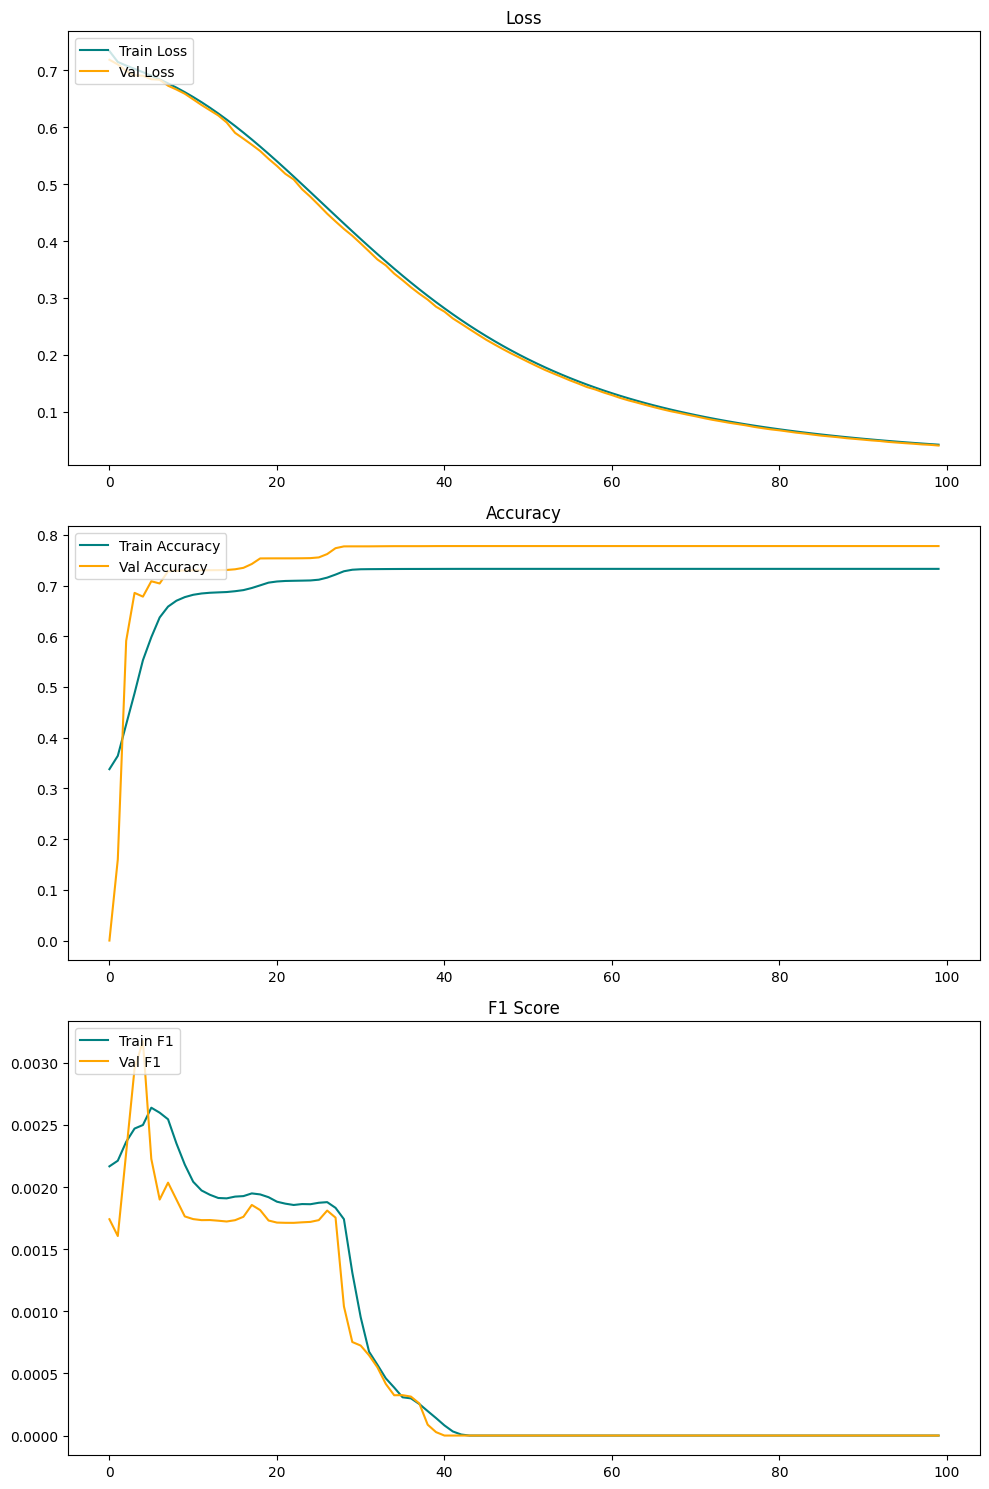

In [9]:
# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=10, path='D:/Mohamed Sheriff/Projects/Computer Vision Internship - Cellula Technologies/Water Segementation/Model/torch_9channels.pth'):
        self.patience = patience
        self.best_loss = None
        self.counter = 0
        self.early_stop = False
        self.path = path

    def __call__(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.path)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                
def binary_accuracy(preds, targets):
    """
    Computes binary accuracy by converting predictions to 0 or 1 based on a threshold of 0.5.
    """
    preds = torch.round(preds)  # Apply threshold of 0.5 to output probabilities
    correct = (preds == targets).float()  # Convert to float for division
    acc = correct.sum() / correct.numel()  # Calculate mean accuracy across all samples
    return acc

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience, model_path, device):
    early_stopping = EarlyStopping(patience=patience, path=model_path)

    # Initialize history dictionary
    history = {'train_loss': [], 'train_acc': [], 'train_f1': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}

    for epoch in range(1, num_epochs + 1):
        start_time = time.time()

        # Training Phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        running_f1 = 0.0
        total_train_samples = 0

        for inputs, targets in tqdm(train_loader, desc=f'Epoch {epoch}/{num_epochs}', leave=False):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            total_train_samples += targets.size(0)

            # Calculate accuracy and F1 score for training
            acc = binary_accuracy(outputs, targets)
            running_corrects += acc.item() * inputs.size(0)

            f1 = f1_score(outputs, targets)
            running_f1 += f1.item() * inputs.size(0)

        epoch_loss = running_loss / total_train_samples
        epoch_acc = running_corrects / total_train_samples
        epoch_f1 = running_f1 / total_train_samples

        # Store metrics for the epoch
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        history['train_f1'].append(epoch_f1)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        val_f1 = 0.0
        total_val_samples = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item() * inputs.size(0)
                total_val_samples += targets.size(0)

                # Calculate accuracy and F1 score for validation
                acc = binary_accuracy(outputs, targets)
                val_corrects += acc.item() * inputs.size(0)

                f1 = f1_score(outputs, targets)
                val_f1 += f1.item() * inputs.size(0)

        val_loss /= total_val_samples
        val_acc = val_corrects / total_val_samples
        val_f1 = val_f1 / total_val_samples

        # Store validation metrics
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)

        elapsed_time = time.time() - start_time

        # Print progress
        print(f'Epoch {epoch}/{num_epochs} '
              f'{len(train_loader)}/{len(train_loader)} [==============================] - '
              f'{elapsed_time:.0f}s - loss: {epoch_loss:.4f} - accuracy: {epoch_acc * 100:.2f}% - f1: {epoch_f1:.4f} ---------------------------------------------- '
              f'val_loss: {val_loss:.4f} - val_accuracy: {val_acc * 100:.2f}% - val_f1: {val_f1:.4f}')

        # Early stopping check
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    return history  # Return the history for plotting
# Setup for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepLabV3Plus().to(device)

# Define optimizer, criterion, and hyperparameters
optimizer = Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
num_epochs = 100
patience = 10
batch_size = 16
model_path = "D:/Mohamed Sheriff/Projects/Computer Vision Internship - Cellula Technologies/Water Segementation/Model/torch_9channels.pth"

# Create DataLoader
train_loader = DataLoader(train_dataset_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset_subset, batch_size=batch_size, shuffle=False)
# Train the model and get the history
history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience, model_path, device)

# Plotting the metrics
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot Loss
axs[0].plot(history['train_loss'], color='teal', label='Train Loss')
axs[0].plot(history['val_loss'], color='orange', label='Val Loss')
axs[0].set_title('Loss')
axs[0].legend(loc="upper left")

# Plot Accuracy
axs[1].plot(history['train_acc'], color='teal', label='Train Accuracy')
axs[1].plot(history['val_acc'], color='orange', label='Val Accuracy')
axs[1].set_title('Accuracy')
axs[1].legend(loc="upper left")

# Plot F1 Score
axs[2].plot(history['train_f1'], color='teal', label='Train F1')
axs[2].plot(history['val_f1'], color='orange', label='Val F1')
axs[2].set_title('F1 Score')
axs[2].legend(loc="upper left")

plt.tight_layout()
plt.show()